In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
import pandas as pd
import pandas_datareader.data as pdr
import numpy

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow import feature_column
from tensorflow.keras import layers

from datetime import datetime, timezone,timedelta

from ta.utils import dropna
from ta.volatility import BollingerBands, AverageTrueRange
from ta.momentum import KAMAIndicator, PercentagePriceOscillator, PercentageVolumeOscillator, ROCIndicator, RSIIndicator, StochasticOscillator
from ta.trend import MACD, ADXIndicator, AroonIndicator
from ta.volume import OnBalanceVolumeIndicator, AccDistIndexIndicator

In [2]:
end = datetime.today() - timedelta(days=46)
start = datetime(2015, 9, 1)
ETH = pdr.DataReader('ETH-USD','yahoo',start,end)

df = pd.DataFrame(data=ETH)

kama_indicator = KAMAIndicator(close = df["Close"], window = 10, pow1 = 2, pow2 = 30, fillna = False)
df['kama'] = kama_indicator.kama()
ppo_indicator = PercentagePriceOscillator(close = df["Close"], window_slow = 20, window_fast = 10, window_sign = 9, fillna = False)
df['ppo'] = ppo_indicator.ppo()
pvo_indicator = PercentageVolumeOscillator(volume = df["Volume"], window_slow = 20, window_fast = 10, window_sign = 9, fillna = False)
df['pvo'] = pvo_indicator.pvo()
roc_indicator = ROCIndicator(close = df["Close"], window = 12, fillna = False)
df['roc'] = roc_indicator.roc()
macd_indicator = MACD(close = df["Close"], window_slow = 20, window_fast = 12, window_sign = 9, fillna = False)
df['macd'] = macd_indicator.macd()
rsi_indicator = RSIIndicator(close = df["Close"], window = 14, fillna = False)
df['rsi'] = rsi_indicator.rsi()
obv_indicator = OnBalanceVolumeIndicator(close = df["Close"], volume = df["Volume"], fillna = False)
df['obv'] = obv_indicator.on_balance_volume() 
adi_indicator = AccDistIndexIndicator(high = df["High"], low = df["Low"], close = df["Close"], volume = df["Volume"], fillna = False)
df['adi'] = adi_indicator.acc_dist_index() 
adx_indicator = ADXIndicator(high = df["High"], low = df["Low"], close = df["Close"], window = 14, fillna = False)
df['adx'] = adx_indicator.adx() 
aroon_indicator = AroonIndicator(close = df["Close"], window = 20, fillna = False)
df['aroon'] = aroon_indicator.aroon_indicator()
stoo_indicator = StochasticOscillator(high = df["High"], low = df["Low"], close = df["Close"], window = 14, smooth_window = 3, fillna = False)
df['stoo'] = stoo_indicator.stoch()
boll_indicator = BollingerBands(close = df["Close"], window = 20, window_dev = 2, fillna = False)
df['boll_mavg'] = boll_indicator.bollinger_mavg()
atr_indicator = AverageTrueRange(high = df["High"], low = df["Low"], close = df["Close"], window = 14, fillna = False)
df['atr'] = atr_indicator.average_true_range()
df = df[30:len(df)]
df = df.drop(df.columns[[0, 1, 2, 4, 5]], axis=1)
df.rename(columns = {"Close": "price"}, inplace=True)
df

/Users/michi/opt/anaconda3/lib/python3.7/site-packages/ta/trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
/Users/michi/opt/anaconda3/lib/python3.7/site-packages/ta/trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])


,price,kama,ppo,pvo,roc,macd,rsi,obv,adi,adx,aroon,stoo,boll_mavg,atr
Date,,,,,,,,,,,,,,
2015-09-30,0.690215,0.811597,-11.489120,2.141859,-21.779006,-0.077372,34.454502,-8.564007e+06,-4.907831e+06,54.215458,-80.0,33.266298,0.834724,0.093193
2015-10-01,0.678574,0.801430,-11.324981,-4.375174,-27.691655,-0.075267,33.882156,-8.783325e+06,-4.839221e+06,53.903292,-65.0,30.357976,0.816716,0.089145
2015-10-02,0.687171,0.793691,-10.933511,-10.759738,-25.230050,-0.072050,34.744284,-8.619999e+06,-4.889321e+06,53.250656,-65.0,32.505797,0.804274,0.085186
2015-10-03,0.668379,0.787789,-10.698761,-17.292239,-25.883568,-0.069632,33.709574,-8.723496e+06,-4.943876e+06,52.758816,-65.0,27.810903,0.793912,0.081416
2015-10-04,0.628643,0.782317,-10.850040,-20.146678,-29.635239,-0.069090,31.568711,-8.957759e+06,-5.138840e+06,52.574517,-40.0,19.758748,0.778123,0.079171
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-19,1377.295898,1200.237877,9.506933,5.776310,12.370116,84.262264,73.763107,1.020205e+12,1.226429e+12,36.968993,90.0,89.159126,1115.582819,121.759777
2021-01-20,1382.274048,1205.775807,9.668640,7.716372,12.912700,87.204738,73.949105,1.066989e+12,1.259694e+12,37.246893,95.0,90.140279,1147.806351,124.665808
2021-01-21,1121.570923,1205.095650,7.805180,8.704535,-12.450954,72.900372,52.827792,1.021056e+12,1.221227e+12,35.729308,90.0,38.757796,1167.366519,136.061697


In [3]:
df.head()

,price,kama,ppo,pvo,roc,macd,rsi,obv,adi,adx,aroon,stoo,boll_mavg,atr
Date,,,,,,,,,,,,,,
2015-09-30,0.690215,0.811597,-11.489120,2.141859,-21.779006,-0.077372,34.454502,-8564007.0,-4.907831e+06,54.215458,-80.0,33.266298,0.834724,0.093193
2015-10-01,0.678574,0.801430,-11.324981,-4.375174,-27.691655,-0.075267,33.882156,-8783325.0,-4.839221e+06,53.903292,-65.0,30.357976,0.816716,0.089145
2015-10-02,0.687171,0.793691,-10.933511,-10.759738,-25.230050,-0.072050,34.744284,-8619999.0,-4.889321e+06,53.250656,-65.0,32.505797,0.804274,0.085186
2015-10-03,0.668379,0.787789,-10.698761,-17.292239,-25.883568,-0.069632,33.709574,-8723496.0,-4.943876e+06,52.758816,-65.0,27.810903,0.793912,0.081416
2015-10-04,0.628643,0.782317,-10.850040,-20.146678,-29.635239,-0.069090,31.568711,-8957759.0,-5.138840e+06,52.574517,-40.0,19.758748,0.778123,0.079171


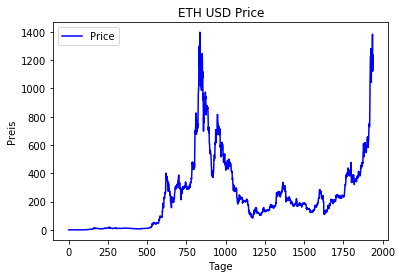

In [4]:
prices = df['price'].to_numpy()

days = range(1, len(prices) + 1)

plt.plot(days, prices, 'blue', label='Price')
plt.title('ETH USD Price')
plt.xlabel('Tage')
plt.ylabel('Preis')
plt.legend()

plt.show()

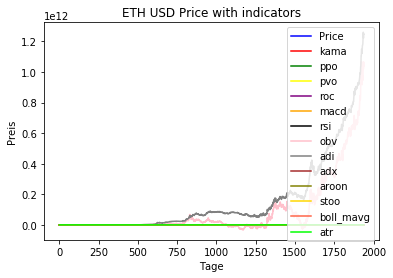

In [5]:
prices = df['price'].to_numpy()
kama = df['kama'].to_numpy()
ppo = df['ppo'].to_numpy()
pvo = df['pvo'].to_numpy()
roc = df['roc'].to_numpy()
macd = df['macd'].to_numpy()
rsi = df['rsi'].to_numpy()
obv = df['obv'].to_numpy()
adi = df['adi'].to_numpy()
adx = df['adx'].to_numpy()
aroon = df['aroon'].to_numpy()
stoo = df['stoo'].to_numpy()
boll_mavg = df['boll_mavg'].to_numpy()
atr = df['atr'].to_numpy()

days = range(1, len(prices) + 1)

plt.plot(days, prices, 'blue', label='Price')
plt.plot(days, kama, 'red', label='kama')
plt.plot(days, ppo, 'green', label='ppo')
plt.plot(days, pvo, 'yellow', label='pvo')
plt.plot(days, roc, 'purple', label='roc')
plt.plot(days, macd, 'orange', label='macd')
plt.plot(days, rsi, 'black', label='rsi')
plt.plot(days, obv, 'pink', label='obv')
plt.plot(days, adi, 'grey', label='adi')
plt.plot(days, adx, 'brown', label='adx')
plt.plot(days, aroon, 'olive', label='aroon')
plt.plot(days, stoo, 'gold', label='stoo')
plt.plot(days, boll_mavg, 'tomato', label='boll_mavg')
plt.plot(days, atr, 'lime', label='atr')
plt.title('ETH USD Price with indicators')
plt.xlabel('Tage')
plt.ylabel('Preis')
plt.legend()

plt.show()

In [6]:
raw_features = []
raw_labels = []

for i in range(20, len(prices)):
    if (i+1 <= len(prices)-1):
        feature = []
        prices_n = prices[i-20:i]
        kama_n = kama[i-20:i]
        ppo_n = ppo[i-20:i]
        pvo_n = pvo[i-20:i]
        roc_n = roc[i-20:i]
        macd_n = macd[i-20:i]
        rsi_n = rsi[i-20:i]
        obv_n = obv[i-20:i]
        adi_n = adi[i-20:i]
        adx_n = adx[i-20:i]
        aroon_n = aroon[i-20:i]
        stoo_n = stoo[i-20:i]
        boll_mavg_n = boll_mavg[i-20:i]
        atr_n = atr[i-20:i]
        normalized_prices = []
        normalized_kama = []
        normalized_ppo = []
        normalized_pvo = []
        normalized_roc = []
        normalized_macd = []
        normalized_rsi = []
        normalized_obv = []
        normalized_adi = []
        normalized_adx = []
        normalized_aroon = []
        normalized_stoo = []
        normalized_boll_mavg = []
        normalized_atr= []
    
        for q in range(20):
            normalized_prices.append(prices_n[q] / prices_n[0])
            normalized_kama.append(kama_n[q] / kama_n[0])
            normalized_ppo.append(ppo_n[q] / ppo_n[0])
            normalized_pvo.append(pvo_n[q] / pvo_n[0])
            normalized_roc.append(roc_n[q] / roc_n[0])
            normalized_macd.append(macd_n[q] / macd_n[0])
            normalized_rsi.append(rsi_n[q] / rsi_n[0])
            #normalized_obv.append(obv_n[q] / obv_n[0])
            #normalized_adi.append(adi_n[q] / adi_n[0])
            normalized_adx.append(adx_n[q] / adx_n[0])
            normalized_aroon.append(aroon_n[q] / aroon_n[0])
            #normalized_stoo.append(stoo_n[q] / stoo_n[0])
            normalized_boll_mavg.append(boll_mavg_n[q] / boll_mavg_n[0])
            normalized_atr.append(atr_n[q] / atr_n[0])
            
        feature.append(normalized_prices)
        feature.append(normalized_kama)
        feature.append(normalized_ppo)
        feature.append(normalized_pvo)
        feature.append(normalized_roc)
        feature.append(normalized_macd)
        feature.append(normalized_rsi)
        #feature.append(normalized_obv)
        #feature.append(normalized_adi)
        feature.append(normalized_adx)
        feature.append(normalized_aroon)
        #feature.append(normalized_stoo)
        feature.append(normalized_boll_mavg)
        feature.append(normalized_atr)
    
        
        raw_features.append(feature)
        
        next_price = prices[i]

        for j in range(1):
            if (next_price > prices[i+1]):
                raw_labels.append(1)
            else:
                raw_labels.append(0)

In [7]:
features = []
labels = []

for i in range(len(raw_features)):
    features.append([list(a) for a in zip(*raw_features[i])])
    labels.append(raw_labels[i])

In [8]:
for i in range(1):
    print('features', features[i])
    print('----')
    print('----')
    print('labels', labels[i])
    print('----')
    
print(len(features))
print(len(labels))

features [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.9831342899230614, 0.9874737603237479, 0.9857135542504778, -2.0426994356287005, 1.2714838841071492, 0.9728040842365492, 0.9833883515667307, 0.9942421196267998, 0.8125, 0.9784260392105573, 0.9565586357154987], [0.9955897666004657, 0.9779378386920253, 0.9516404295097729, -5.023550675801431, 1.1584573574055697, 0.9312181438245238, 1.0084105648810249, 0.9822042996682455, 0.8125, 0.9635209881300288, 0.9140795019216085], [0.9683635054783787, 0.970665673349715, 0.9312080274007015, -8.073471768776736, 1.1884641415816224, 0.8999717449763677, 0.9783793684091758, 0.9731323523301341, 0.8125, 0.9511071249350243, 0.8736289875203155], [0.9107929905354855, 0.9639236552134423, 0.9443752370324558, -9.406163650235188, 1.3607250535045243, 0.8929636440374986, 0.9162434230253897, 0.9697329636747198, 0.5, 0.9321926641022074, 0.8495405287532962], [0.942670074644949, 0.9557173352389401, 0.9171746371611362, -10.134229481251039, 0.9196868921298

In [9]:
def numpy_to_ds(features, labels, batch_size):
    return tf.data.Dataset.from_tensor_slices((features, labels)).batch(batch_size)

In [10]:
dataset = numpy_to_ds(features, labels, 1)

In [11]:
dataset = dataset.shuffle(len(features))

In [12]:
DATASET_SIZE = len(features)

train_size = int(0.7 * DATASET_SIZE)
val_size = int(0.1 * DATASET_SIZE)
test_size = int(0.2 * DATASET_SIZE)

train_ds = dataset.take(train_size)
test_ds = dataset.skip(train_size)
val_ds = dataset.skip(test_size)
test_ds = dataset.take(test_size)

In [13]:
text_batch, label_batch = next(iter(train_ds))
print(text_batch, label_batch)

tf.Tensor(
[[[ 1.          1.          1.          1.          1.
    1.          1.          1.          1.          1.
    1.        ]
  [ 1.00379685  1.00208188  1.27949054  0.917879    0.68326085
    1.24744089  1.00687539  1.01308219  1.05882353  1.00222801
    0.97437356]
  [ 1.10237049  1.02483357  2.08963029  0.69889906  1.35804805
    1.98080094  1.15289713  1.12073728  1.11764706  1.01542323
    1.09781577]
  [ 1.05065167  1.03762901  2.30877257  0.66608385  0.85975994
    2.21824194  1.01924371  1.22109808  1.05882353  1.02648665
    1.1265926 ]
  [ 1.12350475  1.06206776  2.87190087  0.543663    1.83897578
    2.78302758  1.11149721  1.33070568  1.          1.04064753
    1.1820861 ]
  [ 1.07905112  1.06978334  2.95371552  0.45205631  1.95601322
    2.92109552  1.01203535  1.4473929   1.          1.04998326
    1.24318   ]
  [ 1.11071166  1.08677879  3.14642715  0.5745179   1.87078141
    3.16456862  1.05211523  1.55574532  1.          1.06010572
    1.22114372]
  [ 1.11183

In [14]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [16]:
model = tf.keras.Sequential([
  layers.LSTM(64, input_shape=(20, 11)),
  layers.Dropout(0.2),
  layers.Dense(1)
])

model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

history = model.fit(train_ds,
          validation_data=val_ds,
          epochs=20)

model.summary()

Epoch 1/20
1341/1341 [==============================] - 9s 6ms/step - loss: 0.7215 - binary_accuracy: 0.4883 - val_loss: 0.6798 - val_binary_accuracy: 0.5776
Epoch 2/20
1341/1341 [==============================] - 7s 5ms/step - loss: 0.6969 - binary_accuracy: 0.5246 - val_loss: 0.6778 - val_binary_accuracy: 0.5652
Epoch 3/20
1341/1341 [==============================] - 7s 5ms/step - loss: 0.6854 - binary_accuracy: 0.5311 - val_loss: 0.6751 - val_binary_accuracy: 0.5704
Epoch 4/20
1341/1341 [==============================] - 7s 5ms/step - loss: 0.6854 - binary_accuracy: 0.5312 - val_loss: 0.6687 - val_binary_accuracy: 0.5913
Epoch 5/20
1341/1341 [==============================] - 7s 5ms/step - loss: 0.6801 - binary_accuracy: 0.5378 - val_loss: 0.6661 - val_binary_accuracy: 0.5913
Epoch 6/20
1341/1341 [==============================] - 7s 5ms/step - loss: 0.6759 - binary_accuracy: 0.5583 - val_loss: 0.6618 - val_binary_accuracy: 0.6037
Epoch 7/20
1341/1341 [==============================

In [17]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

383/383 [==============================] - 0s 1ms/step - loss: 0.5863 - binary_accuracy: 0.6606
Loss:  0.5863043069839478
Accuracy:  0.6605744361877441


In [18]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

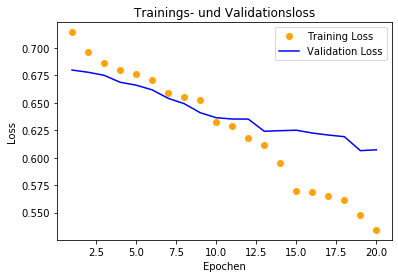

In [19]:
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'o', color='orange', label='Training Loss')
plt.plot(epochs, val_loss, 'blue', label='Validation Loss')
plt.title('Trainings- und Validationsloss')
plt.xlabel('Epochen')
plt.ylabel('Loss')
plt.legend()

plt.show()

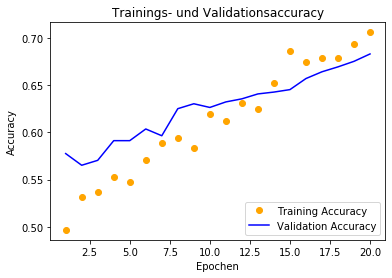

In [20]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']

plt.plot(epochs, acc, 'o', color='orange', label='Training Accuracy')
plt.plot(epochs, val_acc, 'blue', label='Validation Accuracy')
plt.title('Trainings- und Validationsaccuracy')
plt.xlabel('Epochen')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [21]:
feature_batch, label_batch = next(iter(test_ds))
print(feature_batch)

model.predict(feature_batch)

tf.Tensor(
[[[ 1.          1.          1.          1.          1.
    1.          1.          1.          1.          1.
    1.        ]
  [ 0.98482834  1.00016686  0.90762421  1.68596318  0.51541734
    0.9223282   0.95551609  1.00417534  1.          1.0055938
    0.96191166]
  [ 0.99623345  1.00358471  0.86620253  2.23650354  1.1148187
    0.88583053  0.98217559  1.00076953  1.          1.00975313
    0.93358763]
  [ 0.99230871  1.00491758  0.80565846  2.59913919 -0.02158225
    0.83235657  0.96968406  0.997607    0.88888889  1.01579464
    0.90034458]
  [ 0.99434267  1.00510826  0.7543915   3.26511308 -1.48921343
    0.78572856  0.97498968  0.99467036  0.77777778  1.02093719
    0.85542674]
  [ 1.01337873  1.00560003  0.7741016   3.14659766 -0.40091621
    0.79940611  1.02456647  1.01354156  0.66666667  1.02697634
    0.83214515]
  [ 1.00016574  1.00698034  0.72575457  2.84546193  0.03875591
    0.75590246  0.97616941  1.03616366  0.55555556  1.03230711
    0.81325513]
  [ 0.9819884

array([[-1.0867481]], dtype=float32)

In [28]:
end = datetime.today()
start = datetime.today() - timedelta(days=46)
ETH = pdr.DataReader('ETH-USD','yahoo',start,end)

df = pd.DataFrame(data=ETH)

kama_indicator = KAMAIndicator(close = df["Close"], window = 10, pow1 = 2, pow2 = 30, fillna = False)
df['kama'] = kama_indicator.kama()
ppo_indicator = PercentagePriceOscillator(close = df["Close"], window_slow = 20, window_fast = 10, window_sign = 9, fillna = False)
df['ppo'] = ppo_indicator.ppo()
pvo_indicator = PercentageVolumeOscillator(volume = df["Volume"], window_slow = 20, window_fast = 10, window_sign = 9, fillna = False)
df['pvo'] = pvo_indicator.pvo()
roc_indicator = ROCIndicator(close = df["Close"], window = 12, fillna = False)
df['roc'] = roc_indicator.roc()
macd_indicator = MACD(close = df["Close"], window_slow = 20, window_fast = 12, window_sign = 9, fillna = False)
df['macd'] = macd_indicator.macd()
rsi_indicator = RSIIndicator(close = df["Close"], window = 14, fillna = False)
df['rsi'] = rsi_indicator.rsi()
#obv_indicator = OnBalanceVolumeIndicator(close = df["Close"], volume = df["Volume"], fillna = False)
#df['obv'] = obv_indicator.on_balance_volume() 
#adi_indicator = AccDistIndexIndicator(high = df["High"], low = df["Low"], close = df["Close"], volume = df["Volume"], fillna = False)
#df['adi'] = adi_indicator.acc_dist_index() 
adx_indicator = ADXIndicator(high = df["High"], low = df["Low"], close = df["Close"], window = 14, fillna = False)
df['adx'] = adx_indicator.adx() 
aroon_indicator = AroonIndicator(close = df["Close"], window = 20, fillna = False)
df['aroon'] = aroon_indicator.aroon_indicator()
#stoo_indicator = StochasticOscillator(high = df["High"], low = df["Low"], close = df["Close"], window = 14, smooth_window = 3, fillna = False)
#df['stoo'] = stoo_indicator.stoch()
boll_indicator = BollingerBands(close = df["Close"], window = 20, window_dev = 2, fillna = False)
df['boll_mavg'] = boll_indicator.bollinger_mavg()
atr_indicator = AverageTrueRange(high = df["High"], low = df["Low"], close = df["Close"], window = 14, fillna = False)
df['atr'] = atr_indicator.average_true_range()

df = df[26:47]
df =  df.drop(df.columns[[0, 1, 2, 4, 5]], axis=1)

example = df.to_numpy()

model.predict(tf.reshape(example, [1, 20, 11]))

array([[0.58846104]], dtype=float32)